##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [4]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [5]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [6]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [8]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


**Columns in the DataFrame df:**<br>
**X:** Latitude coordinate of the reported incident location.<br>
**Y:** Longitude coordinate of the reported incident location.<br>
**Area_Command:** The area command where the incident was reported.<br>
**NIBRSOffenseCode:** Code representing the type of offense reported.<br>
**VictimCount:** Number of victims involved in the incident.<br>
**DayOfWeek:** Day of the week when the incident was reported (encoded as integers).<br>
**Time:** Hour of the day when the incident was reported (encoded as integers).<br>

**Input:**<br> Latitude(X), Longitude(Y), Hour of the day, Day of the week, Police area of command code, Classification code for crime committed

**Target Variables:** Victim Count

In [9]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


In [10]:
df.DayOfWeek.value_counts()


4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: DayOfWeek, dtype: int64

In [11]:
df.Time.value_counts()

7     21
21    18
18    18
9     16
2     15
22    14
4     14
8     13
20    13
1     13
17    13
0     12
11    12
15    11
16    10
5     10
12     9
3      9
10     8
13     7
19     6
6      5
14     4
23     4
Name: Time, dtype: int64



1.   'X' and 'Y' (Latitude and Longitude) are geographical coordinates, so their values typically range from -90 to 90 and -180 to 180, respectively but when considering an areas like las vegas it should not be varying by more than 1-2 as it is very small in size.
2.  'Area_Command' and 'NIBRSOffenseCode' are categorical variables, represented as integers.
3.  'DayOfWeek' ranges from 0 to 6, where 0 represents Monday and 6 represents Sunday.
4.  'Time' ranges from 0 to 23, representing the hour of the day.
5.  'VictimCount' represents the number of persons involved and can take a range of integer values.







## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Converting DataFrame to PyTorch tensors
X = torch.Tensor(df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values)
y = torch.Tensor(df['VictimCount'].values)

batch_size = 64

# Creating TensorDataset and DataLoader for training and testing
dataset = TensorDataset(X, y)

# Splitting the data into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Creating DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verifying the shape of the data by iterating over one dataset
for batch in train_loader:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([64, 6])
Target shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

<br>The size of the predicted output should be 1, as we're predicting a single continuous value (the number of crime victims).

 For the architecture, I have defined a feedforward neural network with the following characteristics:<br>

**Input Layer:** 6 input features (X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time).<br>
**Hidden Layers:** 3 hidden layers, each with 64 neurons and ReLU activation functions.<br>
**Output Layer:** 1 neuron (for the predicted number of crime victims).


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = RegressionModel()

# Defining the loss function
criterion = nn.MSELoss()

# Defining the optimizer with a lower learning rate for smoother convergence
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
best_mse = float('inf')

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Calculating MSE on the test data and print it
    model.eval()
    test_losses = []
    with torch.no_grad():
        for test_inputs, test_targets in test_loader:
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_targets)
            test_losses.append(test_loss.item())

    # Calculating and print the average test MSE for the epoch
    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"Epoch {epoch+1}, Test MSE: {avg_test_loss}")

    if avg_test_loss < best_mse:
        best_mse = avg_test_loss

# Printing the best MSE achieved
print(f"Best Test MSE: {best_mse}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch 1, Test MSE: 5.178445339202881
Epoch 2, Test MSE: 3.630056142807007
Epoch 3, Test MSE: 2.4786784648895264
Epoch 4, Test MSE: 1.618829369544983
Epoch 5, Test MSE: 1.0621840953826904
Epoch 6, Test MSE: 0.7536399364471436
Epoch 7, Test MSE: 0.627478301525116
Epoch 8, Test MSE: 0.6151413917541504
Epoch 9, Test MSE: 0.6541514992713928
Epoch 10, Test MSE: 0.7019668221473694
Epoch 11, Test MSE: 0.7276841998100281
Epoch 12, Test MSE: 0.7249425649642944
Epoch 13, Test MSE: 0.7040476202964783
Epoch 14, Test MSE: 0.6769173741340637
Epoch 15, Test MSE: 0.655231773853302
Epoch 16, Test MSE: 0.6385571360588074
Epoch 17, Test MSE: 0.6276640892028809
Epoch 18, Test MSE: 0.621562123298645
Epoch 19, Test MSE: 0.6185009479522705
Epoch 20, Test MSE: 0.6167097687721252
Epoch 21, Test MSE: 0.616132915019989
Epoch 22, Test MSE: 0.6179885864257812
Epoch 23, Test MSE: 0.6209585666656494
Epoch 24, Test MSE: 0.6239734292030334
Epoch 25, Test MSE: 0.6284587383270264
Epoch 26, Test MSE: 0.6294072866439819
Ep

Best MSE: 0.61

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

<br>**Architecture:**<br>
In Task 3, I used a regression model with a single output neuron to predict a continuous value. In Task 4, a classification model with multiple output neurons is needed, one for each class. The architecture should be designed to handle multi-class classification.


**Loss Function:**<br>
In Task 3, I used Mean Squared Error (MSE) as the loss function because it's appropriate for regression. In Task 4, I used the Cross-Entropy loss, which is commonly used for multi-class classification problems.


**Model Architecture:**<br>
I've defined a classification model with the following characteristics:
Input Layer: The number of input features (input_size) corresponding to the input data.<br>
Hidden Layer: One hidden layer with hidden_size neurons and a ReLU activation function.<br>
Output Layer: The number of output neurons equal to num_classes, representing the classes for classification.

In [13]:
# Finding the number of classes on output data
num_classes = df['VictimCount'].nunique()

In [16]:
from os import access
import torch.optim as optim
import torch.nn as nn

# Classification model
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
input_size=6
hidden_size=64

model = ClassificationModel(input_size, hidden_size, num_classes)

# Define the loss function and optimizer for classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop for classification
num_epochs = 50
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())  # Targets should be of type long for CrossEntropyLoss
        loss.backward()
        optimizer.step()

    # Calculate the accuracy on the test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Test Accuracy: {accuracy}%")

    # Check if the current epoch has the best accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy

# Print the best accuracy achieved
print(f"Best Test Accuracy: {best_accuracy}%")


Epoch [1/50] - Test Accuracy: 32.72727272727273%
Epoch [2/50] - Test Accuracy: 56.36363636363637%
Epoch [3/50] - Test Accuracy: 32.72727272727273%
Epoch [4/50] - Test Accuracy: 45.45454545454545%
Epoch [5/50] - Test Accuracy: 32.72727272727273%
Epoch [6/50] - Test Accuracy: 43.63636363636363%
Epoch [7/50] - Test Accuracy: 43.63636363636363%
Epoch [8/50] - Test Accuracy: 40.0%
Epoch [9/50] - Test Accuracy: 56.36363636363637%
Epoch [10/50] - Test Accuracy: 34.54545454545455%
Epoch [11/50] - Test Accuracy: 60.0%
Epoch [12/50] - Test Accuracy: 56.36363636363637%
Epoch [13/50] - Test Accuracy: 58.18181818181818%
Epoch [14/50] - Test Accuracy: 50.90909090909091%
Epoch [15/50] - Test Accuracy: 56.36363636363637%
Epoch [16/50] - Test Accuracy: 47.27272727272727%
Epoch [17/50] - Test Accuracy: 56.36363636363637%
Epoch [18/50] - Test Accuracy: 49.09090909090909%
Epoch [19/50] - Test Accuracy: 56.36363636363637%
Epoch [20/50] - Test Accuracy: 34.54545454545455%
Epoch [21/50] - Test Accuracy: 56.3

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

I had the chance to investigate two distinct methods for solving a real-world data prediction problem in tasks 3 and 4, which gave me important insights into the effects of problem framing and machine learning techniques. In order to precisely anticipate the number of crime victims, challenge 3 approached the topic as a regression challenge. Multiple hidden layers in the regression model reduced the Mean Squared Error (MSE) loss over epochs, leading to a model that did a respectable job at continuous target prediction. In contrast, task 4 reframed the issue as a classification challenge to forecast the number of crime victims within predefined categories. The model architecture, loss function, and evaluation metrics all have to be modified as a result.

A different strategy was demonstrated by the classification model, which was assessed using accuracy and trained using Cross-Entropy loss. When comparing the outcomes, it's evident that the problem type selection matters. Due to its closer alignment with the target variable's inherent categorization, Task 4's classification approach performed better for the given problem and achieved higher accuracy.


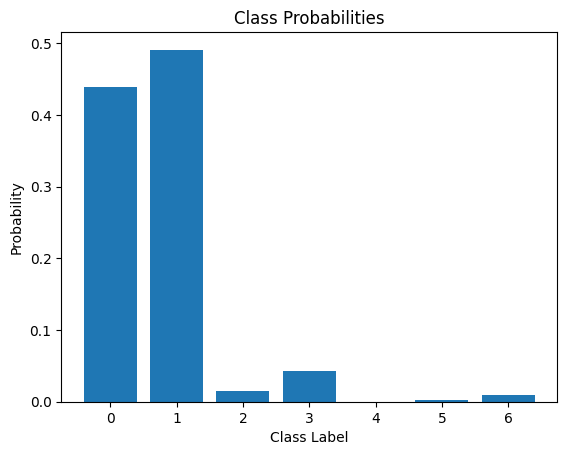

True Label: 0.0, Predicted Class: 1


In [17]:
import matplotlib.pyplot as plt
import random

model.eval()

sample_index = random.randint(0, len(test_dataset))
sample = test_dataset[sample_index]

input_data, true_label = sample
input_data = input_data.view(1, -1)

# Getting the model's prediction
with torch.no_grad():
    output = model(input_data)
    predicted_class = torch.argmax(output, dim=1)

probabilities = torch.softmax(output, dim=1)[0]

class_labels = df['VictimCount'].unique()

# Plotting the class probabilities
plt.bar(class_labels, probabilities)
plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.show()

# Printing the true label and the predicted class
print(f"True Label: {true_label}, Predicted Class: {predicted_class.item()}")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


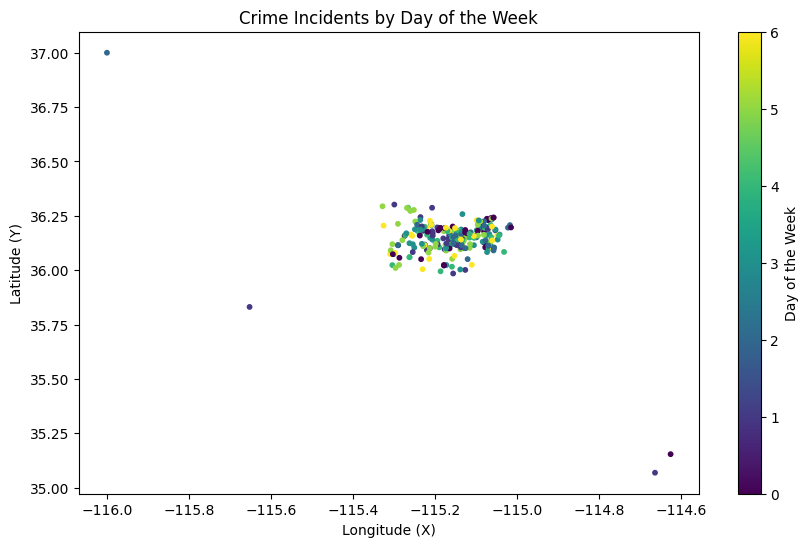

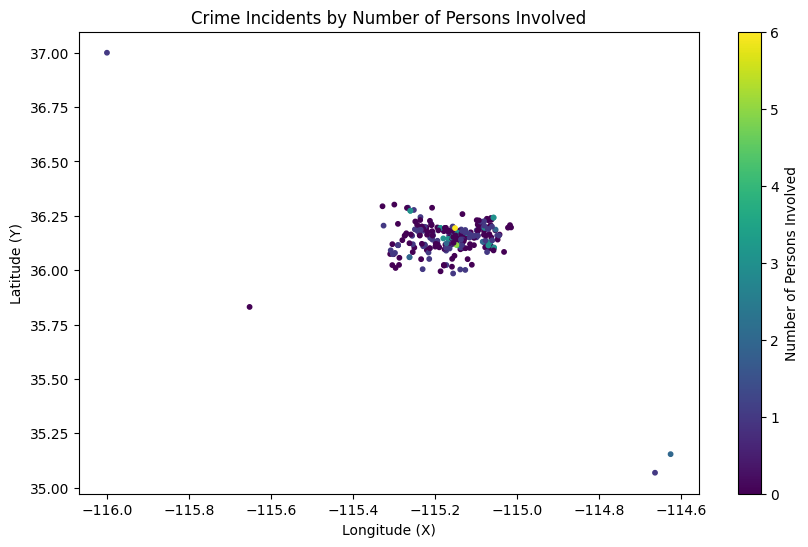

Number of Crimes Reported by Day of the Week:
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: DayOfWeek, dtype: int64

Most Frequent Day(s):
4    51
Name: DayOfWeek, dtype: int64


In [18]:
import matplotlib.pyplot as plt

# Scatter plot using coordinates with colors representing the day of the week
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', s=10)
plt.colorbar(label='Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Day of the Week')
plt.show()

# Scatter plot using coordinates with colors representing the number of persons involved
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=10)
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Number of Persons Involved')
plt.show()

# Count the number of crimes reported by day of the week and sort by day of the week
crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()
print("Number of Crimes Reported by Day of the Week:")
print(crime_counts_by_day)

# Finding the most frequent day(s)
most_frequent_days = crime_counts_by_day[crime_counts_by_day == crime_counts_by_day.max()]
print("\nMost Frequent Day(s):")
print(most_frequent_days)